# __Feauters/Layers Visualization__

# __Imports__

In [0]:
import random

import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from IPython.display import HTML as printHTML

from tensorflow.keras.applications.resnet_v2 import \
ResNet152V2, decode_predictions, preprocess_input

from tensorflow.python.keras import backend as K

tf.compat.v1.disable_eager_execution()

In [0]:
input_size = (224, 224)
input_shape = (*input_size, 3)

assert(K.image_data_format() == 'channels_last')

# __Download ResNet152v2 model__

In [3]:
model = ResNet152V2(
    include_top=True, 
    weights='imagenet'
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


# __Input loading__

In [0]:
files = [
          'zebra.jpg','hog.jpg','tiger.png',
          'elephant.jpg','ostrich.jpg', 'tiger_2.png'
        ]

def load_input(filename):
  img = Image.open(filename).convert('RGB')
  width, height = img.size 
  minimal = min(width, height)
  shift_x, shift_y = (width - minimal)//2, (height - minimal)//2
  img = img.crop((shift_x, shift_y, width - shift_x, height - shift_y))
  img = img.resize(input_size)

  x = preprocess_input(np.expand_dims(np.asarray(img), 0))
  return img, x

# __Print&Plot utils__

In [0]:
def plot_many(images, size=(14, 14), w=5, h=1):
  f = plt.figure(figsize=size)
  for i, img in enumerate(images):
    f.add_subplot(h, w, i+1)
    plt.imshow(img)
    plt.axis('off')
  plt.show()

def formatLabelsHTML(labels):
  html = ''
  for i, (_, name, prob) in enumerate(labels):
    html += '{}. <b>{}:</b> {:.3f}%<br>'\
            .format(i+1, name.capitalize(), prob*100)
  return html

# __Prediction demo__

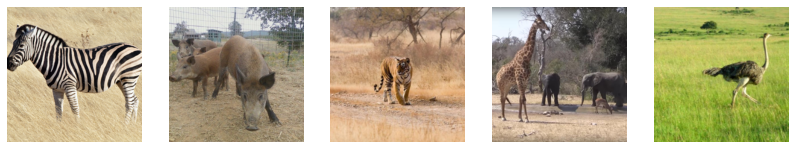

In [6]:
results_html = ''

for i, file in enumerate(files[:5]):
  _, x = load_input(file)
  y = model.predict(x)
  results_html += '<b>Image</b> {}<br>'.format(file)
  results_html += formatLabelsHTML(decode_predictions(y)[0]) + '<br>'

plot_many(list(map(lambda f: load_input(f)[0], files[:5])), w=5)
printHTML(results_html)

In [0]:
import time
from tensorflow.python.keras.preprocessing.image import save_img
from tensorflow.python.keras import layers
from scipy.ndimage.filters import gaussian_filter

def normalize(x):
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())

def layer_by_name(model, layer_name):
  for layer in model.layers[1:]:
    if layer.name == layer_name:
      return layer
  return None

def visualize_grad(model, filename):
  input_layer = model.inputs[0]
  output_layer = layer_by_name(model, 'predictions')

  img, x = load_input(filename)
  img = np.asarray(img)

  y = model.predict(x)
  neuron_index = y[0].argmax()
  
  loss = K.mean(output_layer.output[:, neuron_index])
  grads = normalize(K.gradients(loss, input_layer)[0])
  iterate = K.function([input_layer], [loss, grads])

  loss_value, grads_value = iterate([x])

  means = np.expand_dims(
      gaussian_filter(grads_value.max(axis=3)[0], sigma=5)
  , 2)

  std = means.std()
  img = np.where(means > 0.0*std, img, img * 0.6)
  img = np.where(means > 0.5*std, img, img * 0.6)
  img = np.where(means > 1.0*std, img, img * 0.6)
  img = np.where(means > 1.5*std, img, img * 0.6)
  img = np.where(means > 2.5*std, img, img * 0.6)

  return img.astype(int)

def visualize_change(model, filename, tile=28):
  assert(input_size[0] % tile == 0 and input_size[1] % tile == 0 )

  input_layer = model.inputs[0]
  output_layer = layer_by_name(model, 'predictions')

  img, x = load_input(filename)
  img = np.asarray(img)

  y = model.predict(x)
  neuron_index = y[0].argmax()

  val = y[0][neuron_index]

  res = np.ones(input_shape)

  xs = []

  for i in range(input_size[0]//tile):
    for j in range(input_size[1]//tile):
      x_cut = x.copy()
      x_cut[:, i*tile:(i+1)*tile, j*tile: (j+1)*tile, :] = 0
      xs.append(x_cut[0])

  ys = model.predict(np.vstack([xs]))

  for i in range(input_size[0]//tile):
    for j in range(input_size[1]//tile):
      val_cut = ys[i*(input_size[0]//tile) + j][neuron_index]
      res[i*tile:(i+1)*tile, j*tile: (j+1)*tile, :] = val - val_cut - 1e-6
  
  res = np.where(res > 0, res, 0)
  res /= res.max()
  res = np.sqrt(res)
  #res = np.clip((res*255).astype(int), 0, 255)
  res = gaussian_filter(res, sigma = 8)

  return np.clip((res * img).astype(int), 0, 255)

def visualize_layer(model, filename, layer_name):
  input_layer = model.inputs[0]
  output_layer = layer_by_name(model, layer_name)

  img, x = load_input(filename)
  img = np.asarray(img)

  iterate = K.function([input_layer], [output_layer.output])

  output = iterate([x])

  res = list(output[0].transpose(0, 3, 1, 2)[0])
  #res.sort(key = lambda a: -a.max())

  return res

def visualize_kernels(model, layer_name):
  output_layer = layer_by_name(model, layer_name)
  w = output_layer.get_weights()[0].transpose(3, 0, 1, 2)[:,:,:,:3]
  w -= w.min(axis=0)
  w /= w.max(axis=0)
  return list(w)

# __Kernels visualization__

### __Layer 1__

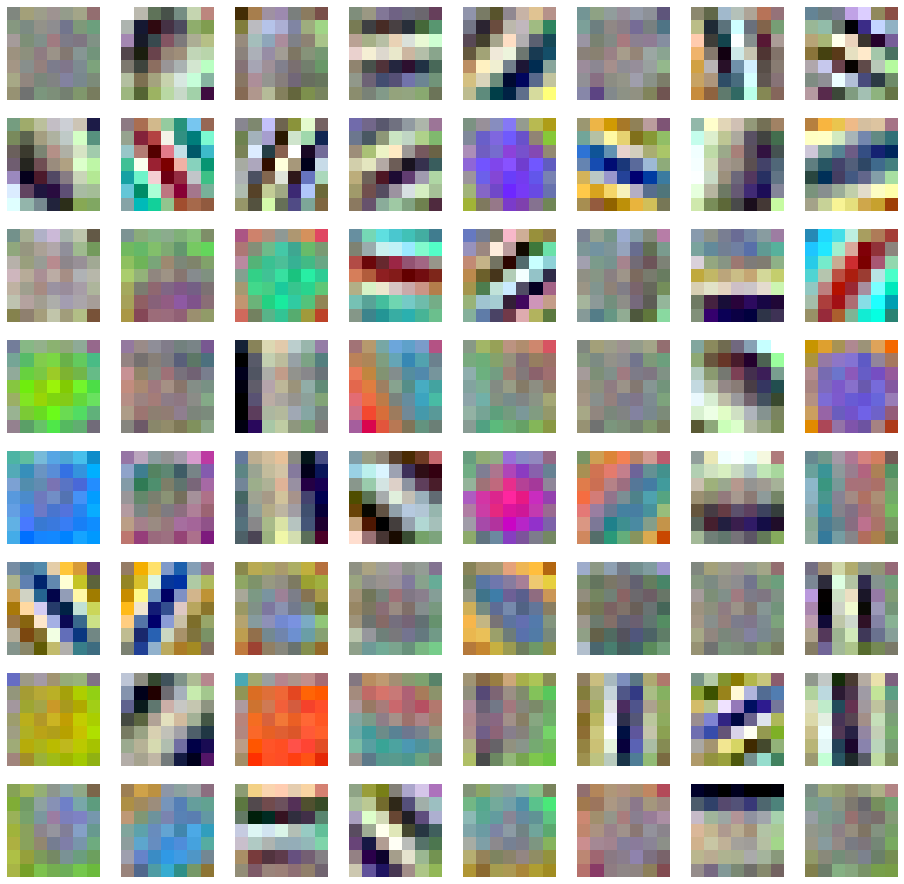

In [8]:
vis_kernels = visualize_kernels(model, 'conv1_conv')

plot_many(vis_kernels[:64], size=(16, 16), w=8, h=8)

### __Layer 9__

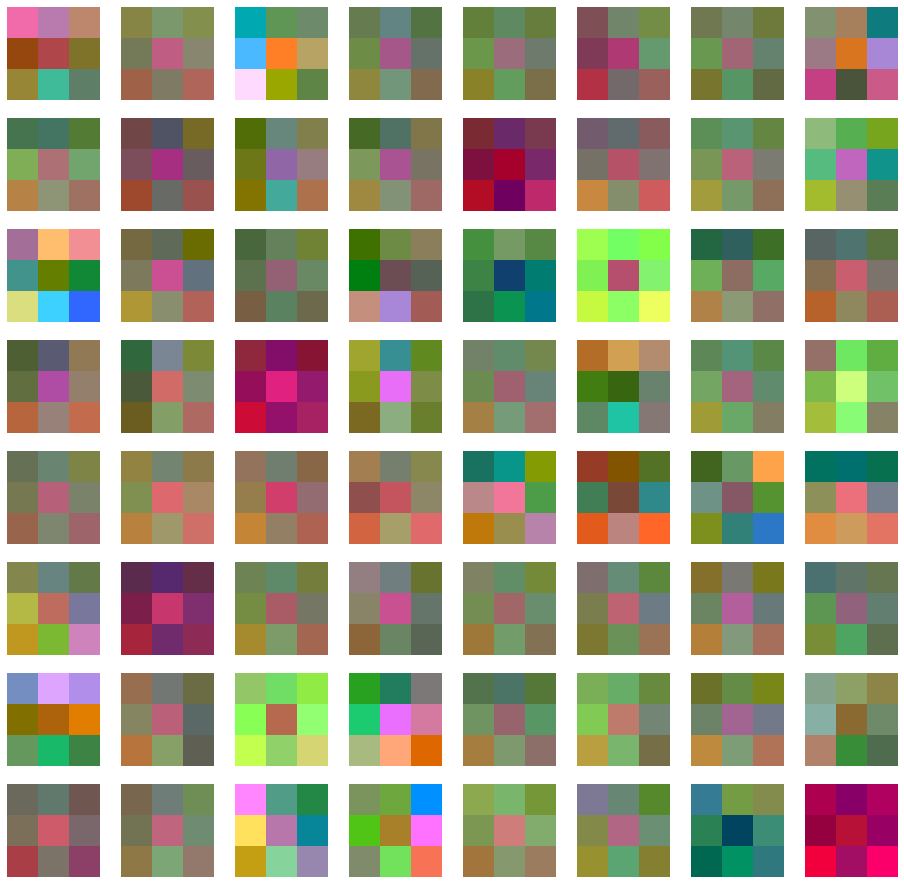

In [10]:
vis_kernels = visualize_kernels(model, 'conv2_block3_2_conv')

plot_many(vis_kernels[:64], size=(16, 16), w=8, h=8)

# __Activation visualization__

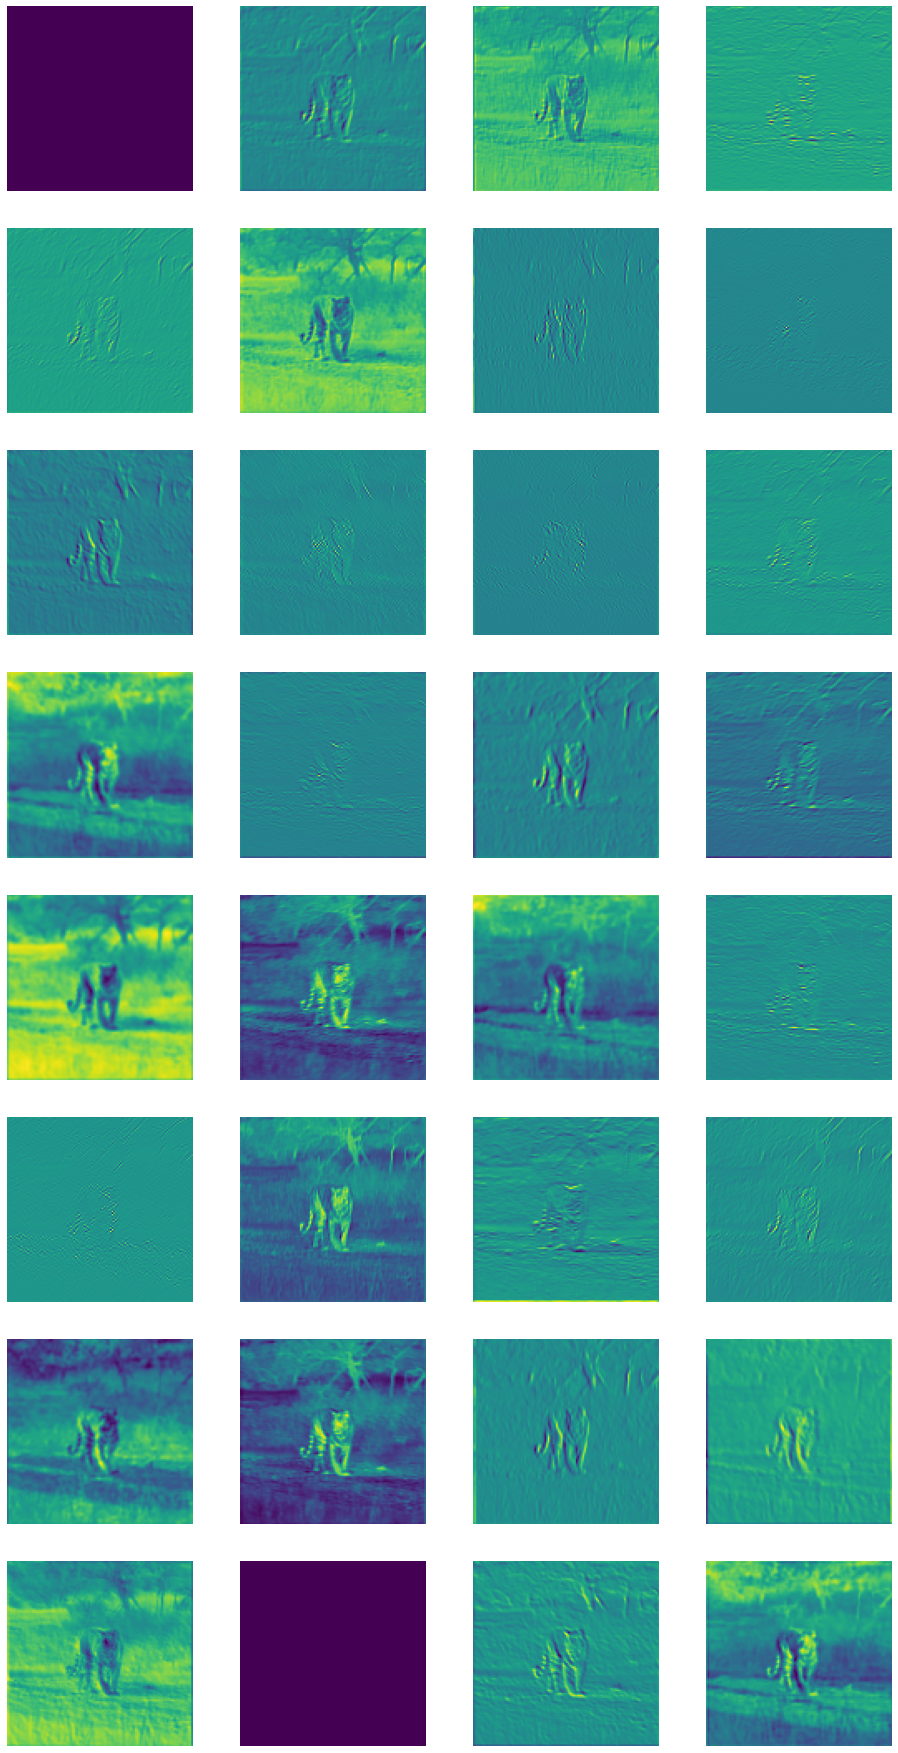

In [11]:
vis_layer = visualize_layer(model, files[2], 'conv1_conv')

plot_many(vis_layer[:32], size=(16, 32), w=4, h=8)

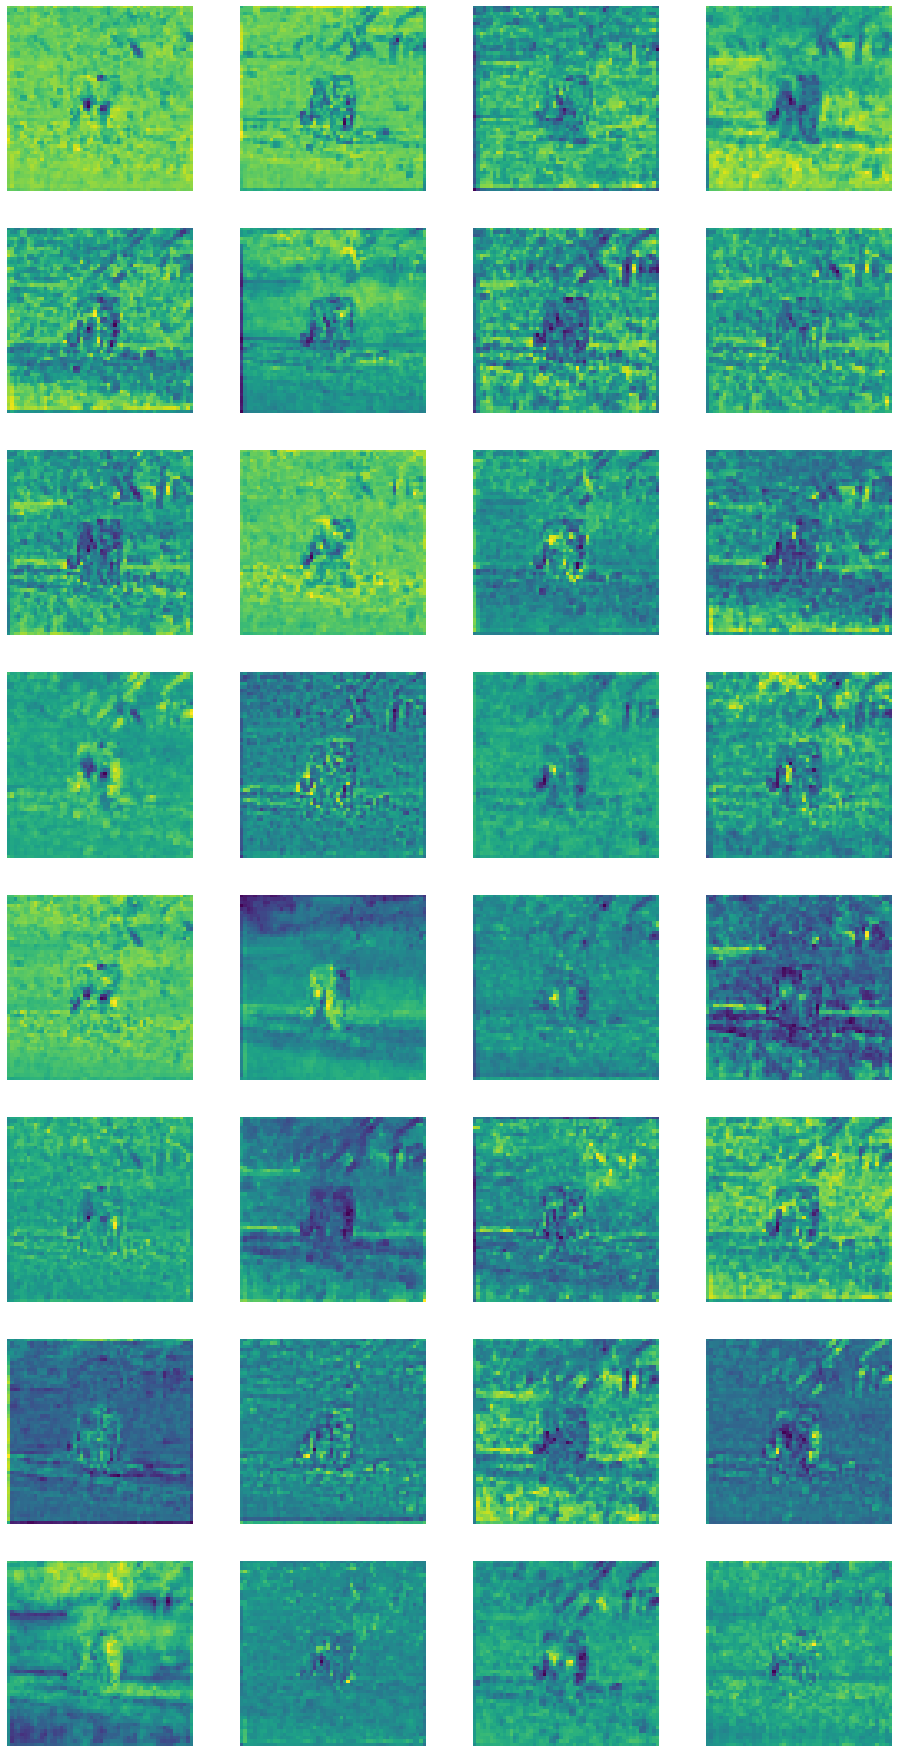

In [12]:
vis_layer = visualize_layer(model, files[2], 'conv2_block2_1_conv')

plot_many(vis_layer[:32], size=(16, 32), w=4, h=8)

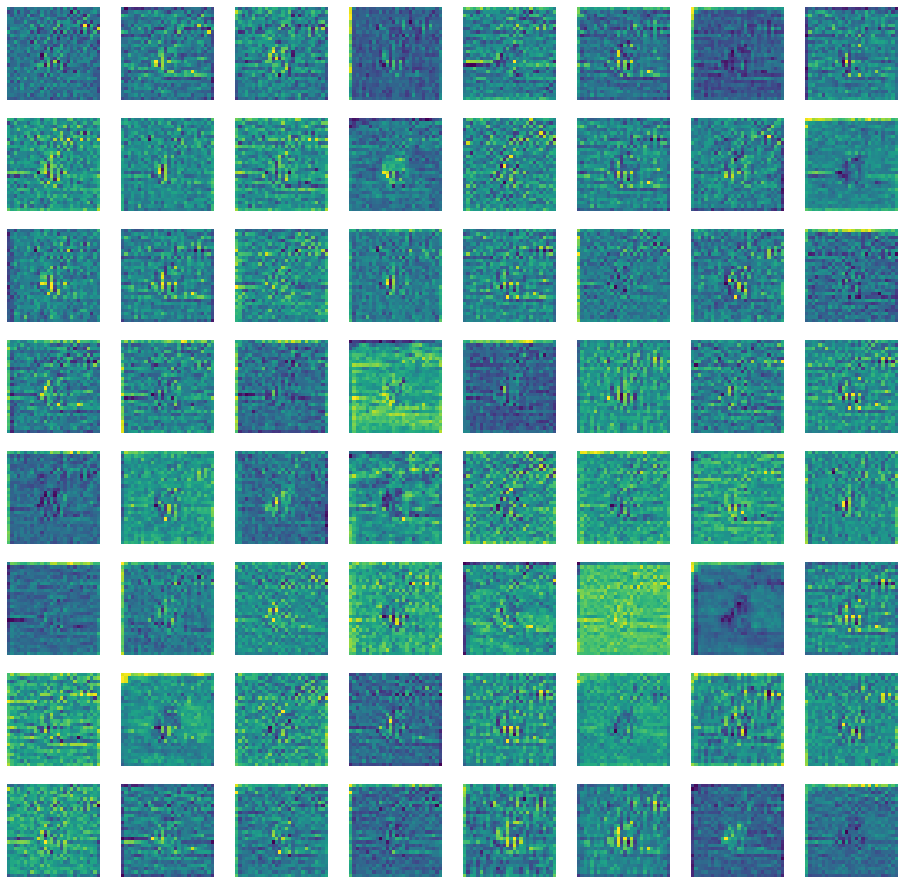

In [13]:
vis_layer = visualize_layer(model, files[2], 'conv2_block3_3_conv')

plot_many(vis_layer[:64], size=(16, 16), w=8, h=8)

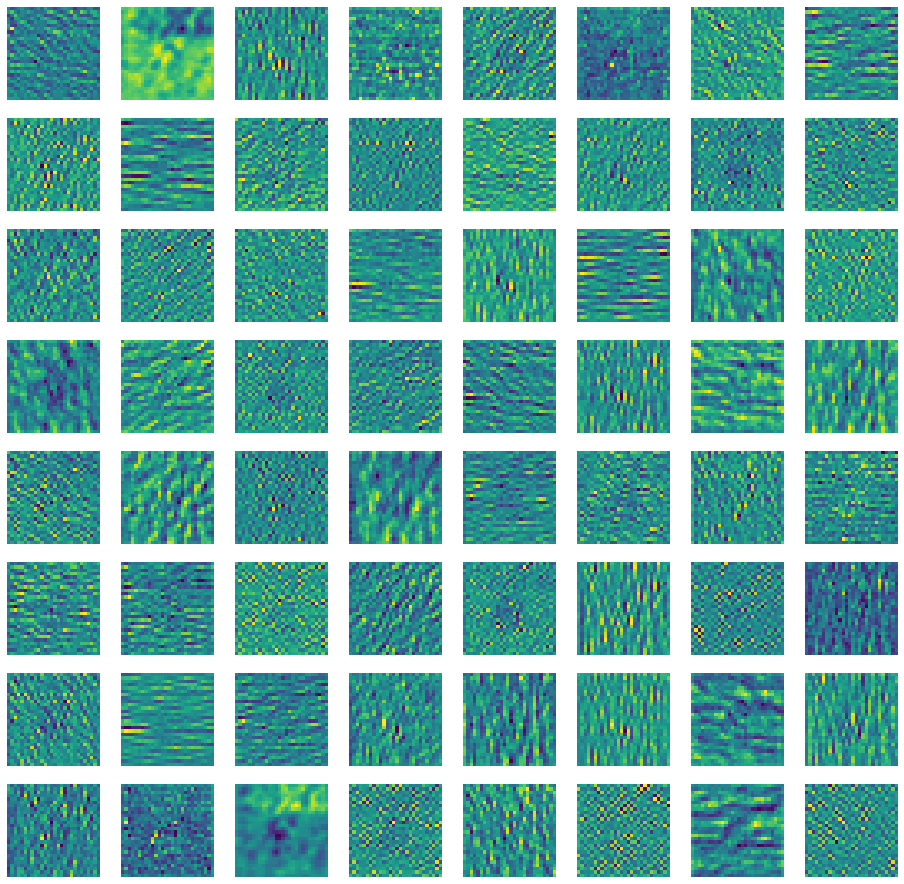

In [14]:
vis_layer = visualize_layer(model, files[2], 'conv3_block7_2_conv')

plot_many(vis_layer[:64], size=(16, 16), w=8, h=8)

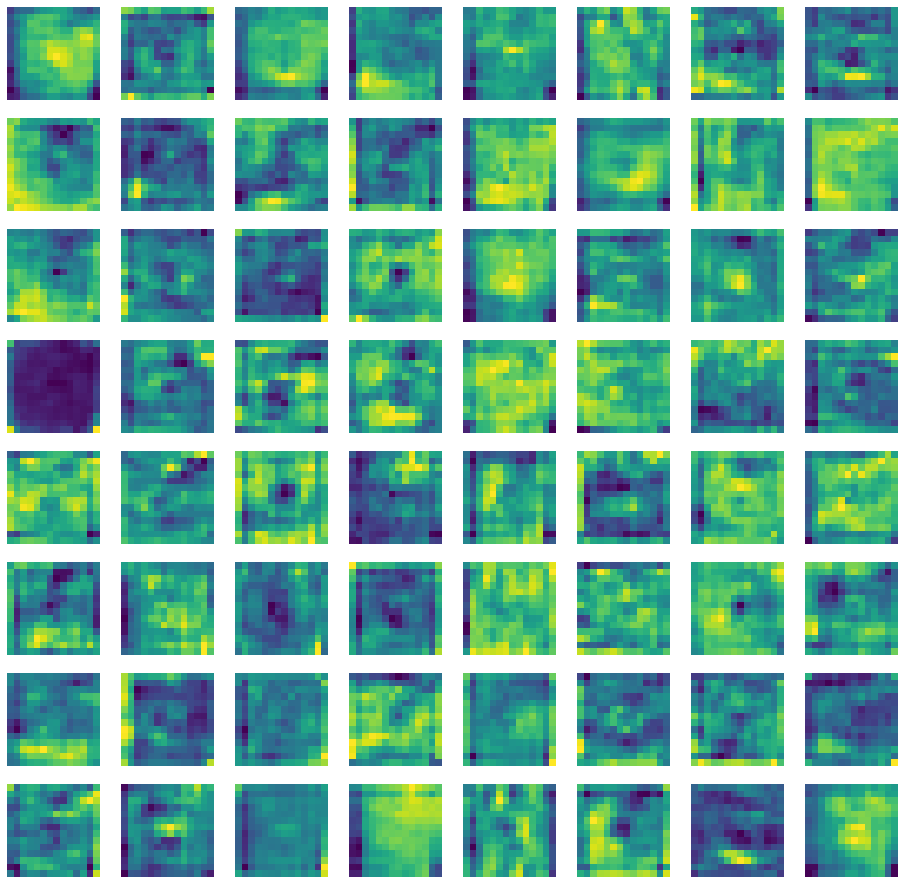

In [15]:
vis_layer = visualize_layer(model, files[2], 'conv4_block25_2_conv')

plot_many(vis_layer[:64], size=(16, 16), w=8, h=8)

### Last convolutional layer

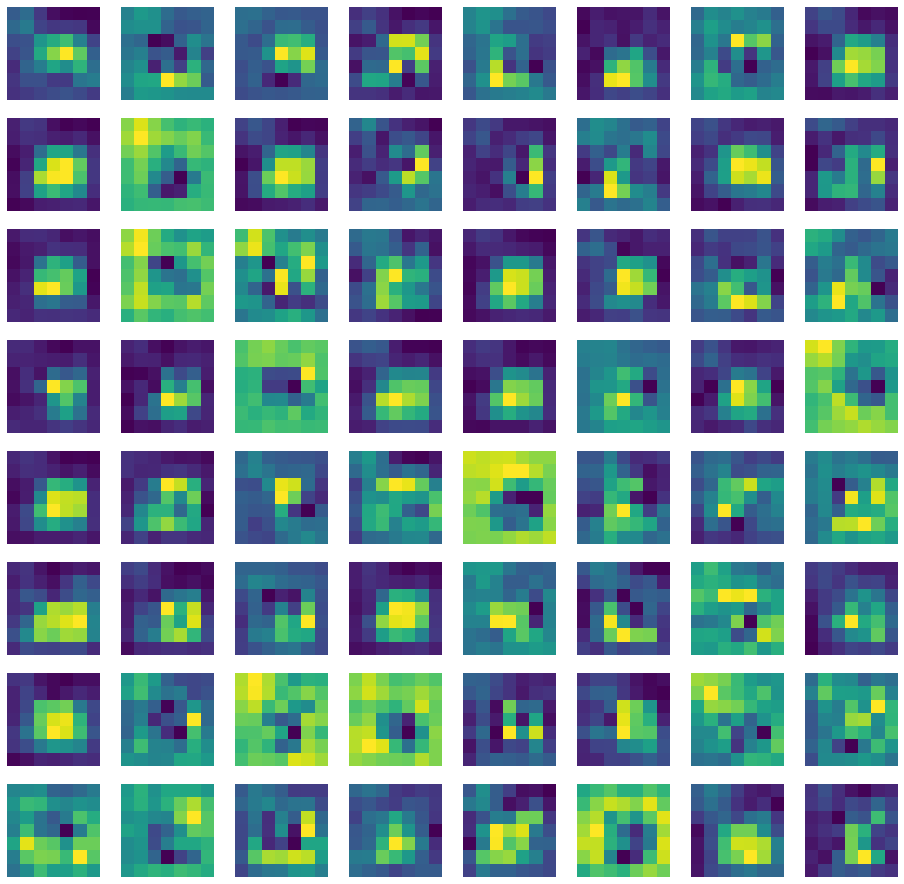

In [16]:
vis_layer = visualize_layer(model, files[2], 'conv5_block3_3_conv')

plot_many(vis_layer[:64], size=(16, 16), w=8, h=8)

### Tiger with offset left

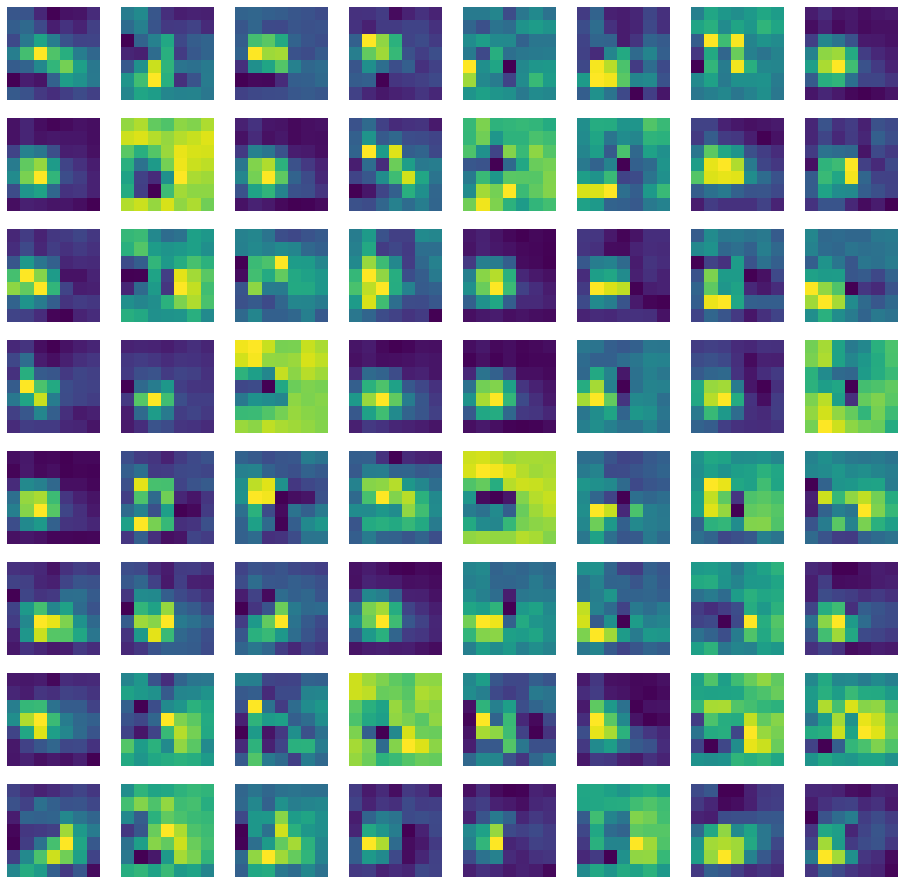

In [17]:
vis_layer = visualize_layer(model, files[5], 'conv5_block3_3_conv')

plot_many(vis_layer[:64], size=(16, 16), w=8, h=8)

# __Area of interest__

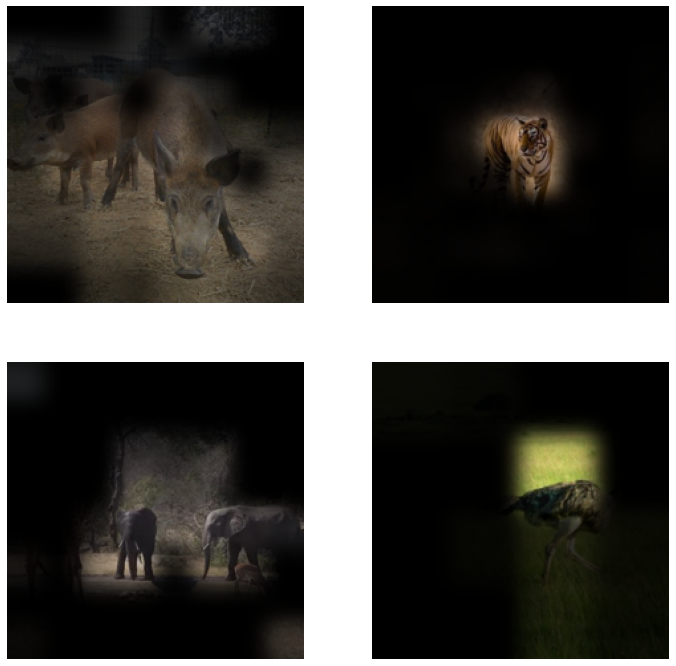

In [18]:
vis_change = [
    visualize_change(model, files[1]),
    visualize_change(model, files[2]),
    visualize_change(model, files[3]),
    visualize_change(model, files[4], tile=56)
]

plot_many(vis_change, size=(12, 12), w=2, h=2)

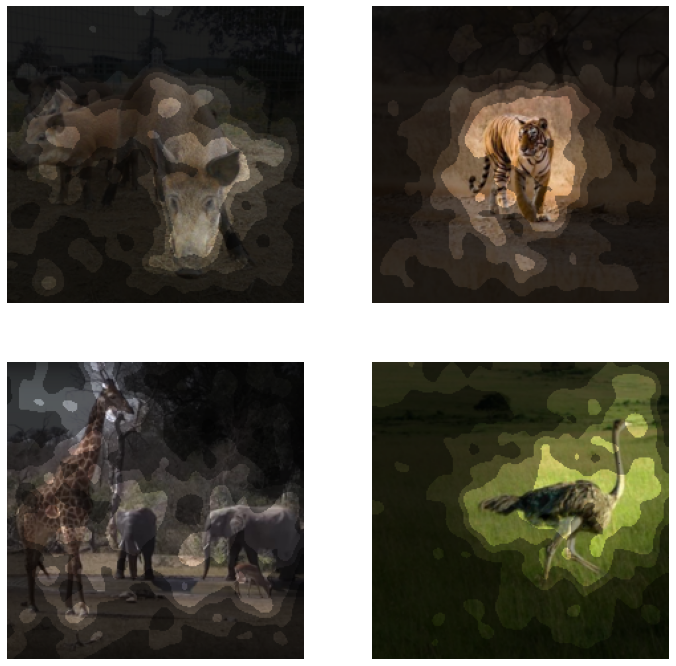

In [19]:
vis_grad = [
    visualize_grad(model, files[1]),
    visualize_grad(model, files[2]),
    visualize_grad(model, files[3]),
    visualize_grad(model, files[4])
]

plot_many(vis_grad, size=(12, 12), w=2, h=2)